# STA-Lab-4
mesa fire lab
dowloaded mesa module to anaconda


In [ ]:
#importing necesary modules for conducting mesa analysis
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

#allows for taking data and examining the output in a DEM style result
from numpy.random import uniform
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter

In [3]:
#setting up the model
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

In [4]:
#creating a counter to collect the data at each time step through the model and to stop collecting data
#when the model has run its course
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

In [20]:
#time to run the model

#1000X1000 grid and density of 0.6
fire = ForestFire(1000, 1000, 0.6)

In [ ]:
#run the model through 1 full time
fire.run_model()

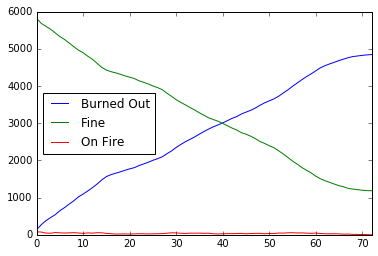

In [7]:
#visually represent the results
results = fire.dc.get_model_vars_dataframe()

#put the results on a graph
results.plot()

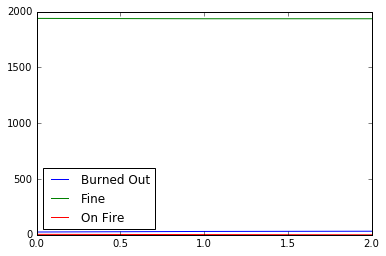

In [8]:
#lets make the tree density small and see what changes
#for example 0.2

fire = ForestFire(1000, 1000, 0.2)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

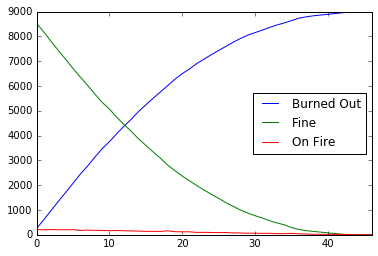

In [9]:
#now lets make the tree density larger and see what happens
#for example .9

fire = ForestFire(1000, 1000, 0.9)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

As seen in the three density graphs above, as the forest density increases the number of trees burned increases. in the final plot the forest completely burns away, with zero "fine" trees left at the end of cycle; while the low density forest maintained the majority of its tree population. 

In [10]:
#creating the parameters to run batch runs on the site and dtermine when tree burning intensity is
#highest
param_set = dict(height=50, # Height and width are constant
                 width=50,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])

# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }

# Create the batch runner
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)

In [11]:
#running the batchrunner over the study period
#using runall() to run it over every possible tree denisty 
param_run.run_all()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00,  8.11it/s]


In [12]:
#placing all the data colected into a data frame that can be visualized
df = param_run.get_model_vars_dataframe()
df.head()

,BurnedOut,Run,density,height,width
0,0.023881,11,0.12,50,50
1,1.000000,98,0.99,50,50
2,0.157177,48,0.49,50,50
3,0.033898,3,0.04,50,50
4,0.122857,42,0.43,50,50


(0, 1)

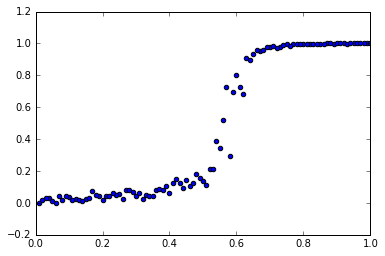

In [14]:
#plot the burned out fractions along a scatter plot 

plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

based on the plot, starting at around 0.5 the trees begin to catch fire and quickly move from very few being burned to nearly all of them being burned at around 0.7. 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00,  7.99it/s]


(0, 1)

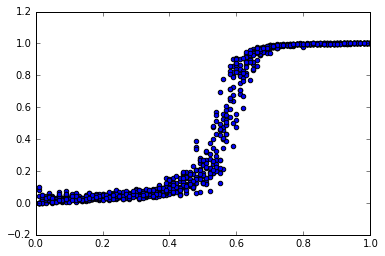

In [16]:
#to gain a higher statistical significance result multiple iterations need to be conduted on the study 
#site to account for variiations between runs
#for this we will do 10 interations
param_run = BatchRunner(ForestFire, param_set, iterations=10, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

this yielded similar resukts to the single intertion method; however this places almost all of the rapid change around the 0.6 mark with some interations seeing earlier burn, while others see later burning. 

In [18]:
#taking what we have and placing it on a fake dem to help visulaize
def fake_surface(dim=(100,100), low=500, high=1500, sigma=2):
    '''Super basic random terrain function.
    
    This function generates a uniform random surface,
    and applies a sequence (x and y) of one-dimensional
    convolution filters; effectively increasing the spatial
    autocorrelation of the surface relative to sigma.
    
    Paramters
    ---------
    dim : tuple
        The x and y dimensions of the 'terrain' grid.
    low : numeric
        The lowest possible simulated elevation value.
    high : numeric
        The highest possible simulated elevation value.
    sigma : numeric
        The variance of the gaussian kernel. Controls
        the 'smoothness' of the simulated surface.
        Values between 1 and 3 are probably good for
        'small' surfaces.
        
    Returns
    -------
    out : ndarray
        A spatially autocorrelated random 'terrain' surface
        of a given dimension.
    '''
    r = uniform(low, high, size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)

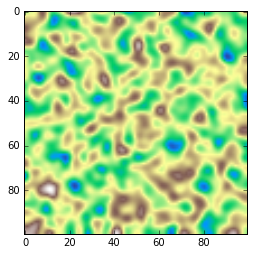

In [19]:
plt.imshow(fake_surface((100,100)), cmap=plt.get_cmap("terrain"))
plt.show()